In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
movies=pd.read_csv('movies.csv')
ratings=pd.read_csv('ratings.csv')
tags=pd.read_csv('genome-tags.csv')
tag_relevance=pd.read_csv('genome-scores.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [89]:
tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [88]:
tag_relevance.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


In [46]:
most_relevant=pd.DataFrame(tag_relevance.groupby('movieId')['relevance'].nlargest(1)).reset_index()
most_relevant.rename(columns={'level_1':'entry'},inplace=True)
most_relevant['entry']=most_relevant['entry'].astype('int64')
most_relevant.head()

,movieId,entry,relevance
0,1,1035,0.99950
1,2,1156,0.97800
2,3,3156,0.97000
3,4,4499,0.97625
4,5,4962,0.96925


In [90]:
most_relevant['entry']=most_relevant['entry'].apply(lambda x:tags.iloc[tag_relevance.iloc[x-1,1]-1]['tag'])
most_relevant.rename(columns={'entry':'tag'})

,movieId,tag,relevance
0,1,touching,0.99950
1,2,adultery,0.97800
2,3,sentimental,0.97000
3,4,wizards,0.97625
4,5,good romantic comedies,0.96925
...,...,...,...
13171,185435,not funny,0.88750
13172,185585,pg,0.76700
13173,186587,survival,0.91875
13174,187593,pixar animation,0.85325


In [92]:
combined_ratings_tags=pd.merge(ratings, most_relevant,on='movieId',how='inner')

In [96]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
number_user_voted = ratings.groupby('movieId')['rating'].agg('count')
number_movies_voted = ratings.groupby('userId')['rating'].agg('count')

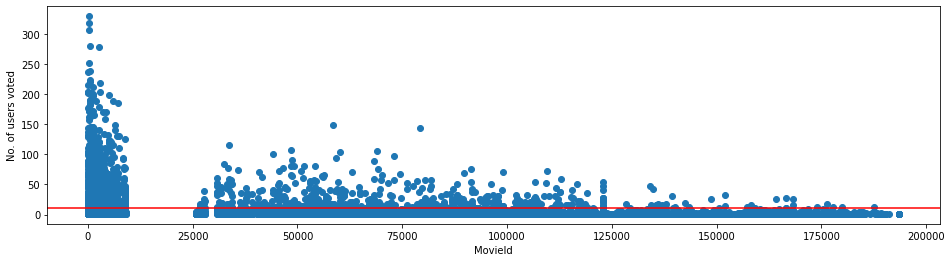

In [104]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(number_user_voted.index,number_user_voted)
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [105]:
final_dataset = final_dataset.loc[number_user_voted[number_user_voted > 10].index,:]
final_dataset=final_dataset.loc[:,number_movies_voted[number_movies_voted > 50].index]
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [106]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [143]:
def get_movie_recommendation(movie_name,n_recommendations):
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):
        movie_idx=movie_list.iloc[0]['movieId']
        movie_idx=final_dataset[final_dataset['movieId']==movie_idx].index[0]
        distances,indices=knn.kneighbors(csr_data[movie_idx],n_neighbors=n_recommendations+1)
        rec_movie_indices=sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x:x[1])[:0:-1]
        recommend_frame=[]
        for val in rec_movie_indices:
            movie_idx=final_dataset.iloc[val[0]]['movieId']
            idx=movies[movies['movieId']==movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Similarity':val[1],'Keywords':movies.iloc[idx]['genres'].values[0].split('|')})
        df=pd.DataFrame(recommend_frame,index=range(1,n_recommendations+1))
        return df
    else:
        return "No movies found. Please check your input"

In [144]:
get_movie_recommendation('Star Wars',10)

,Title,Similarity,Keywords
1,Terminator 2: Judgment Day (1991),0.340150,"[Action, Sci-Fi]"
2,Saving Private Ryan (1998),0.337670,"[Action, Drama, War]"
3,"Terminator, The (1984)",0.334241,"[Action, Sci-Fi, Thriller]"
4,Star Wars: Episode I - The Phantom Menace (1999),0.330408,"[Action, Adventure, Sci-Fi]"
5,Back to the Future (1985),0.325253,"[Adventure, Comedy, Sci-Fi]"
6,Indiana Jones and the Last Crusade (1989),0.302614,"[Action, Adventure]"
7,"Matrix, The (1999)",0.277609,"[Action, Sci-Fi, Thriller]"
8,Raiders of the Lost Ark (Indiana Jones and the...,0.245158,"[Action, Adventure]"
9,Star Wars: Episode VI - Return of the Jedi (1983),0.167382,"[Action, Adventure, Sci-Fi]"
10,Star Wars: Episode V - The Empire Strikes Back...,0.125600,"[Action, Adventure, Sci-Fi]"
